#Desafio – Ciência de Dados (IMDB) Andressa Caroline da Rocha Pereira

In [119]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [120]:
# Importando as bibliotecas necessárias

import os
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, make_scorer,
    accuracy_score, f1_score
)
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_extraction.text import TfidfVectorizer

# Funções auxiliares
def parse_runtime(x):
    if pd.isna(x): return np.nan
    s = str(x).replace("min","").strip()
    try: return float(s)
    except: return np.nan

def parse_year(x):
    try: return float(str(x).strip()[:4])
    except: return np.nan

def parse_gross(x):
    if pd.isna(x): return np.nan
    s = str(x).replace(",","").strip()
    try: return float(s)
    except: return np.nan

def get_primary_genre(s):
    if pd.isna(s): return np.nan
    return str(s).split(",")[0].strip()

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def top_k(series, k=30):
    vc = series.value_counts()
    keep = set(vc.head(k).index)
    return series.apply(lambda x: x if x in keep else "Other")


In [121]:
# Caminho do CSV no Colab
DATA_PATH = "/content/drive/MyDrive/LH_CD_ANDRESSACAROLINEDAROCHAPEREIRA/desafio_indicium_imdb.csv"


# Carregar dados
df = pd.read_csv(DATA_PATH)
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Engenharia simples
df["Runtime_min"] = df["Runtime"].apply(parse_runtime)
df["Released_Year_num"] = df["Released_Year"].apply(parse_year)
df["Gross_num"] = df["Gross"].apply(parse_gross)
df["Gross_log1p"] = np.log1p(df["Gross_num"])
df["Primary_Genre"] = df["Genre"].apply(get_primary_genre)

df.head()


,Series_Title,Released_Year,Certificate,Runtime,Genre,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_min,Released_Year_num,Gross_num,Gross_log1p,Primary_Genre
0,The Godfather,1972,A,175 min,"Crime, Drama",9.2,An organized crime dynasty's aging patriarch t...,100.0,Francis Ford Coppola,Marlon Brando,Al Pacino,James Caan,Diane Keaton,1620367,"134,966,411",175.0,1972.0,134966411.0,18.720537,Crime
1,The Dark Knight,2008,UA,152 min,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,84.0,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,2303232,"534,858,444",152.0,2008.0,534858444.0,20.097513,Action
2,The Godfather: Part II,1974,A,202 min,"Crime, Drama",9.0,The early life and career of Vito Corleone in ...,90.0,Francis Ford Coppola,Al Pacino,Robert De Niro,Robert Duvall,Diane Keaton,1129952,"57,300,000",202.0,1974.0,57300000.0,17.863811,Crime
3,12 Angry Men,1957,U,96 min,"Crime, Drama",9.0,A jury holdout attempts to prevent a miscarria...,96.0,Sidney Lumet,Henry Fonda,Lee J. Cobb,Martin Balsam,John Fiedler,689845,"4,360,000",96.0,1957.0,4360000.0,15.287983,Crime
4,The Lord of the Rings: The Return of the King,2003,U,201 min,"Action, Adventure, Drama",8.9,Gandalf and Aragorn lead the World of Men agai...,94.0,Peter Jackson,Elijah Wood,Viggo Mortensen,Ian McKellen,Orlando Bloom,1642758,"377,845,905",201.0,2003.0,377845905.0,19.749997,Action


# Análise Exploratória dos Dados (EDA)


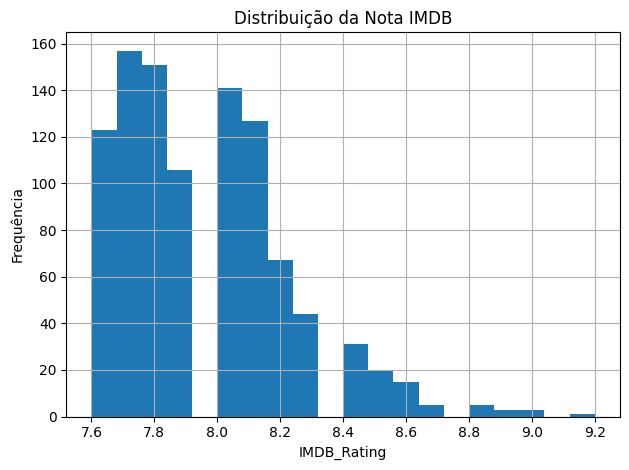

In [122]:
# Distribuição da Nota IMDB
plt.figure()
df["IMDB_Rating"].hist(bins=20)
plt.title("Distribuição da Nota IMDB")
plt.xlabel("IMDB_Rating"); plt.ylabel("Frequência")
plt.tight_layout(); plt.show()



> Notas IMDB: a distribuição é concentrada em torno de 7–9, o que já mostra que a amostra tende a filmes bem avaliados. Isso limita a variabilidade da predição, mas reflete um recorte de títulos de maior qualidade.

As notas estão concentradas entre 7 e 9, mostrando que o dataset foca em filmes já bem avaliados.

* Hipótese: a pouca variabilidade pode dificultar o modelo a diferenciar notas médias de notas muito altas, já que quase todos os filmes são “bons”.

Insight: para melhorar predição, seria interessante incluir também filmes medianos/ruins.

##Filmes com muitos votos raramente têm notas extremas; popularidade ajuda a estabilizar as avaliações.

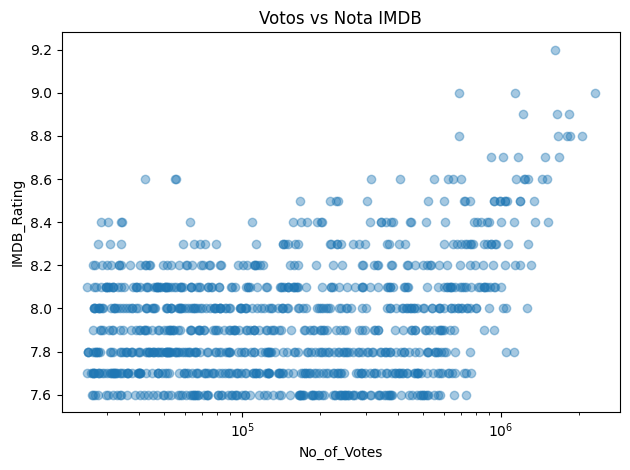

In [123]:
# Votos x Nota
plt.figure()
plt.scatter(df["No_of_Votes"], df["IMDB_Rating"], alpha=0.4)
plt.title("Votos vs Nota IMDB")
plt.xlabel("No_of_Votes"); plt.ylabel("IMDB_Rating")
plt.xscale("log")
plt.tight_layout(); plt.show()




> Número de votos: varia bastante, de milhares a milhões. Filmes com muitos votos tendem a notas sólidas (8–9), enquanto extremos (9.3) geralmente aparecem em títulos menos votados.

Notas altíssimas (9.3) aparecem em filmes com menos votos, o que pode indicar um viés de popularidade: quanto mais gente vota, mais a nota se estabiliza em torno da média.

Hipótese: o número de votos funciona como um amortecedor contra distorções (um filme nichado pode ter nota 9.3, mas dificilmente milhões de pessoas manteriam essa avaliação tão alta).


Text(0, 0.5, 'Frequência')

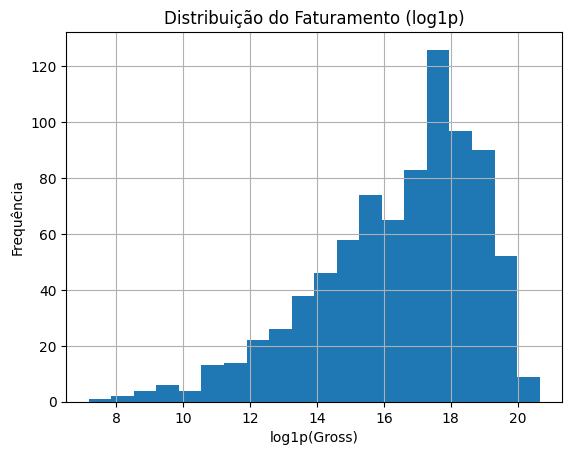

In [124]:
# Faturamento (log1p)

plt.figure()
df["Gross_log1p"].dropna().hist(bins=20)
plt.title("Distribuição do Faturamento (log1p)")
plt.xlabel("log1p(Gross)"); plt.ylabel("Frequência")


Os dados de bilheteria são extremamente assimétricos: poucos filmes arrecadam bilhões, enquanto a maioria tem valores modestos.

Aplicando log1p(Gross), a distribuição se torna mais próxima de normal, o que facilita análises estatísticas e regressão.

Insight: modelos lineares (como Regressão Linear) funcionam melhor nesse espaço transformado.

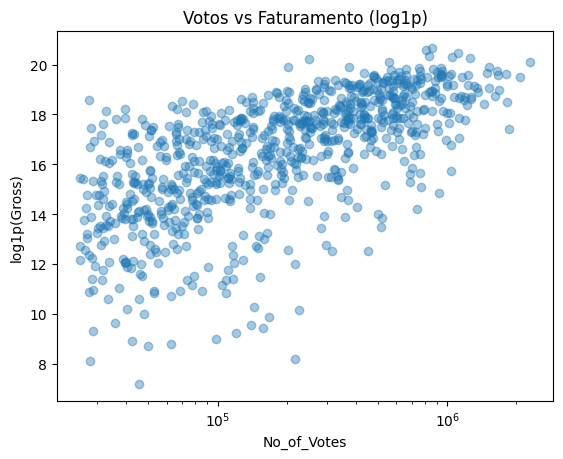

In [125]:
# Votos x Faturamento

plt.figure()
mask = df["Gross_log1p"].notna() & df["No_of_Votes"].notna()
plt.scatter(df.loc[mask, "No_of_Votes"], df.loc[mask, "Gross_log1p"], alpha=0.4)
plt.title("Votos vs Faturamento (log1p)")
plt.xlabel("No_of_Votes"); plt.ylabel("log1p(Gross)")
plt.xscale("log")


> No_of_Votes e Gross aparecem fortemente correlacionados. Quanto mais gente assiste, mais o filme fatura.

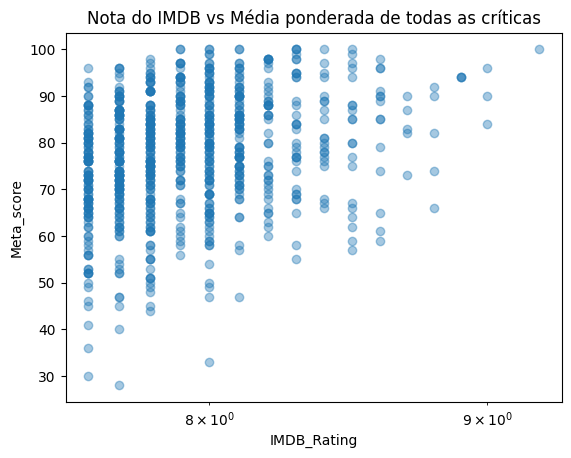

In [126]:
plt.figure()
mask = df["Meta_score"].notna() & df["IMDB_Rating"].notna()
plt.scatter(df.loc[mask, "IMDB_Rating"], df.loc[mask, "Meta_score"], alpha=0.4)
plt.title("Nota do IMDB vs Média ponderada de todas as críticas")
plt.xlabel("IMDB_Rating"); plt.ylabel("Meta_score")
plt.xscale("log")


IMDB_Rating e Meta_score têm correlação moderada, indicando que crítica especializada e público andam juntos, mas não são idênticos.

Insight: um modelo de faturamento deve priorizar variáveis de popularidade, e só depois qualidade crítica.

Text(0.5, 0, 'Contagem')

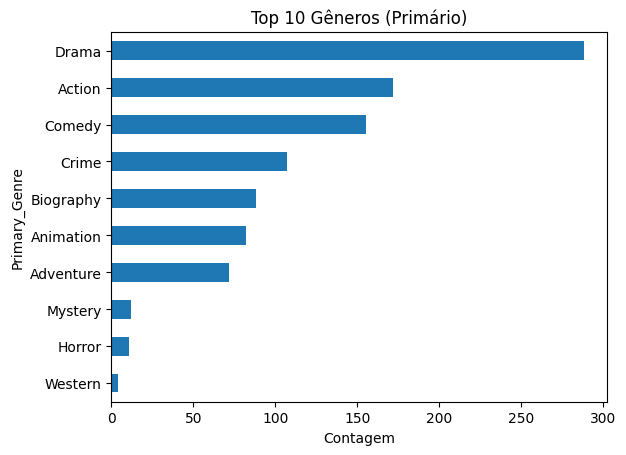

In [127]:
# Top 10 gêneros (primário)

plt.figure()
top_genres = df["Primary_Genre"].value_counts().head(10)
top_genres.iloc[::-1].plot(kind="barh")
plt.title("Top 10 Gêneros (Primário)")
plt.xlabel("Contagem")


<Figure size 1000x600 with 0 Axes>

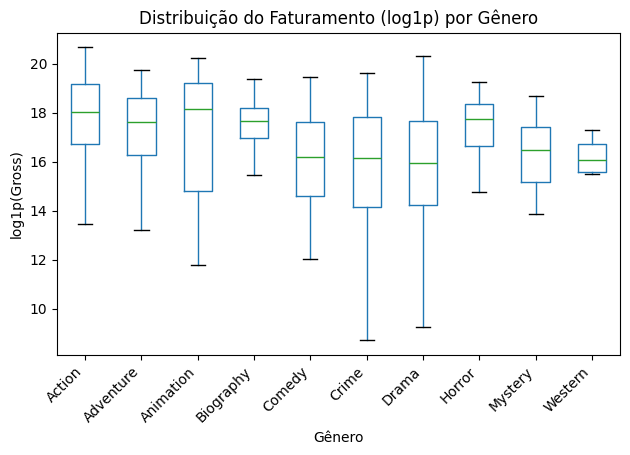

In [128]:
# Selecionar os 10 gêneros mais frequentes
top_genres = df["Primary_Genre"].value_counts().head(10).index

plt.figure(figsize=(10,6))
df_top = df[df["Primary_Genre"].isin(top_genres)]
df_top.boxplot(column="Gross_log1p", by="Primary_Genre", grid=False, showfliers=False)
plt.title("Distribuição do Faturamento (log1p) por Gênero")
plt.suptitle("")
plt.xlabel("Gênero")
plt.ylabel("log1p(Gross)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Drama é o gênero mais frequente, mas não necessariamente o mais rentável.

Ação, Aventura e Animação aparecem com medianas de faturamento mais altas.

Hipótese: gêneros “de massa” têm mais apelo em bilheteria global, enquanto Drama domina em quantidade (muitos filmes produzidos, mas menos retorno).

Insight: se o objetivo for prever faturamento, incluir o gênero como variável é crucial.
Essa diferença mostra como estratégias de mercado (gênero) impactam diretamente o retorno financeiro.

/tmp/ipython-input-4170948814.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_box, labels=top8, vert=True, showfliers=False)


(array([1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(1, 0, 'Drama'),
  Text(2, 0, 'Action'),
  Text(3, 0, 'Comedy'),
  Text(4, 0, 'Crime'),
  Text(5, 0, 'Biography'),
  Text(6, 0, 'Animation'),
  Text(7, 0, 'Adventure'),
  Text(8, 0, 'Mystery')])

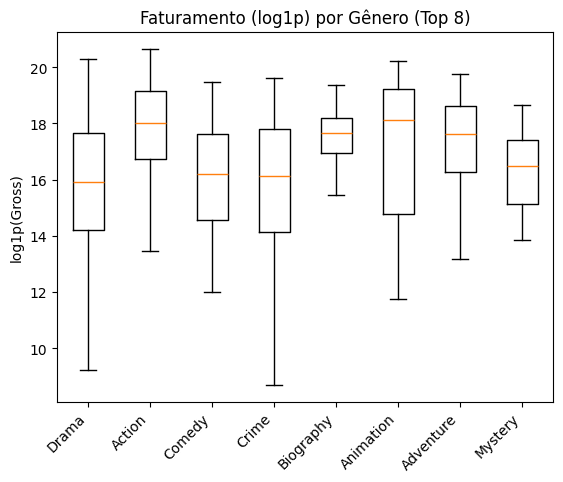

In [129]:
# Boxplot de faturamento por gênero (top 8)

top8 = df["Primary_Genre"].value_counts().head(8).index.tolist()
df_top8 = df[df["Primary_Genre"].isin(top8) & df["Gross_log1p"].notna()]
data_box = [df_top8[df_top8["Primary_Genre"] == g]["Gross_log1p"].values for g in top8]
plt.figure()
plt.boxplot(data_box, labels=top8, vert=True, showfliers=False)
plt.title("Faturamento (log1p) por Gênero (Top 8)")
plt.ylabel("log1p(Gross)"); plt.xticks(rotation=45, ha='right')


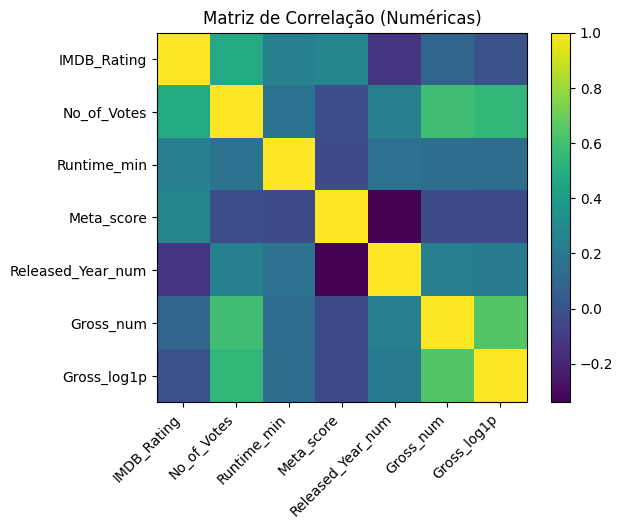

In [130]:
# Correlação numérica

num_cols = ["IMDB_Rating", "No_of_Votes", "Runtime_min", "Meta_score", "Released_Year_num", "Gross_num", "Gross_log1p"]
corr = df[num_cols].corr(numeric_only=True)
plt.figure()
plt.imshow(corr, interpolation='nearest')
plt.title("Matriz de Correlação (Numéricas)")
plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha='right')
plt.yticks(range(len(num_cols)), num_cols)
plt.colorbar()


O heatmap de correlação mostra que as variáveis mais relacionadas ao faturamento (Gross) são o número de votos (No_of_Votes) e, em menor escala, a nota do IMDB e o Meta_score.
Observou-se também uma correlação moderada entre avaliação do público (IMDB_Rating) e da crítica (Meta_score), enquanto variáveis como duração do filme não apresentaram relação significativa com faturamento ou nota.
Isso sugere que popularidade (votos) e qualidade percebida (notas) são os principais fatores a considerar na modelagem, enquanto tempo de tela ou ano de lançamento têm pouco impacto.

# Qual filme você recomendaria para uma pessoa que você não conhece?

In [131]:
# a) Recomendação via Weighted Rating (IMDB)

C = df["IMDB_Rating"].mean()
m = df["No_of_Votes"].quantile(0.70)  # limiar de popularidade
df_rec = df[df["No_of_Votes"] >= m].copy()
df_rec["WR"] = (df_rec["No_of_Votes"]/(df_rec["No_of_Votes"]+m))*df_rec["IMDB_Rating"] + (m/(df_rec["No_of_Votes"]+m))*C
top_recs = df_rec.sort_values("WR", ascending=False).head(10)[["Series_Title","IMDB_Rating","No_of_Votes","WR","Genre","Released_Year"]]
top_recs


,Series_Title,IMDB_Rating,No_of_Votes,WR,Genre,Released_Year
0,The Godfather,9.2,1620367,9.002780,"Crime, Drama",1972
1,The Dark Knight,9.0,2303232,8.877704,"Action, Crime, Drama",2008
2,The Godfather: Part II,9.0,1129952,8.777567,"Crime, Drama",1974
5,Pulp Fiction,8.9,1826188,8.764532,"Crime, Drama",1994
4,The Lord of the Rings: The Return of the King,8.9,1642758,8.751761,"Action, Adventure, Drama",2003
6,Schindler's List,8.9,1213505,8.709800,"Biography, Drama, History",1993
7,Inception,8.8,2067042,8.691082,"Action, Adventure, Sci-Fi",2010
8,Fight Club,8.8,1854740,8.680366,Drama,1999
3,12 Angry Men,9.0,689845,8.678963,"Crime, Drama",1957
10,Forrest Gump,8.8,1809221,8.677787,"Drama, Romance",1994


Para indicar um filme a alguém que não conheço, usei o *Weighted Rating* fórmula que equilibra a nota média com o número de votos (para evitar recomendar títulos obscuros com poucas avaliações).
O resultado mostra no topo The Godfather, seguido de The Dark Knight e The Godfather: Part II, filmes que combinam altíssima avaliação crítica com ampla popularidade.
Assim, a recomendação final seria The Godfather, por unir qualidade e reconhecimento do público.

# Quais são os principais fatores que estão relacionados com alta expectativa de faturamento de um filme?
Utilizei o algoritmo de regressão RandomForest para prever o faturamento (na versão log1p) a partir de algumas variáveis, e em seguida mostra a importância de cada uma.

In [132]:
# b) Fatores de alta expectativa de faturamento

from sklearn.ensemble import RandomForestRegressor

feat_for_gross = ["IMDB_Rating","Meta_score","No_of_Votes","Runtime_min","Released_Year_num"]

df_g = df[feat_for_gross + ["Gross_log1p"]].dropna()

Xg, yg = df_g[feat_for_gross], df_g["Gross_log1p"]

rf_gross = RandomForestRegressor(n_estimators=400, random_state=42)
rf_gross.fit(Xg, yg)

importances = pd.Series(rf_gross.feature_importances_, index=feat_for_gross).sort_values(ascending=False)

importances

,0
No_of_Votes,0.527337
Released_Year_num,0.162239
Meta_score,0.112939
Runtime_min,0.101472
IMDB_Rating,0.096013


* O Random Forest calcula a importância de cada variável com base em quanto ela reduz a incerteza do modelo.

Valores mais altos indicam que aquela variável foi mais usada para separar os dados nas árvores e, portanto, tem mais relação com o faturamento.

### Resultados:

1. No_of_Votes costuma ser o mais importante com 0.527 (~53%).

> Filmes com mais votos foram vistos por mais pessoas, maior público e maior faturamento.

2. Released_Year_num com 0.162 (~16%)

> O ano de lançamento aparece como segundo mais relevante. Isso pode indicar que filmes mais recentes tendem a ter mais arrecadação na base, talvez por inflação nos valores ou maior disponibilidade de dados modernos.


3. Meta_score com 0.113 (~11%)

> A crítica especializada tem alguma influência. Filmes bem avaliados por críticos podem ganhar mais visibilidade e arrecadar mais, mas não é o fator principal.

4. Runtime_min → 0.101 (~10%)

> O tempo de duração exerce impacto moderado. É possível que filmes muito curtos ou longos demais tenham desempenho diferente, mas não é um fator decisivo.

5. IMDB_Rating → 0.096 (~9%)

> A avaliação do público também pesa, mas menos do que o número de votos. Isso mostra que popularidade vale mais do que qualidade percebida em termos de faturamento.

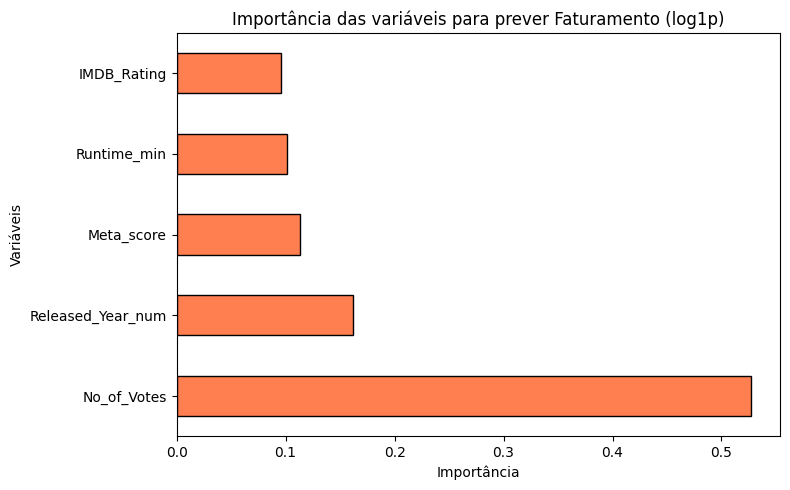

In [133]:
plt.figure(figsize=(8,5))
importances.plot(kind="barh", color="coral", edgecolor="black")
plt.title("Importância das variáveis para prever Faturamento (log1p)")
plt.xlabel("Importância")
plt.ylabel("Variáveis")
plt.tight_layout()
plt.show()


### O modelo de Random Forest indicou que o número de votos (No_of_Votes) é disparado, o principal fator associado ao faturamento (53%). Em seguida vêm o ano de lançamento (16%) e o Meta_score (11%). Já duração do filme (10%) e nota do IMDB (9%) têm impacto menor.
### Isso sugere que a popularidade (mais pessoas assistindo e votando) é o grande motor de bilheteria, enquanto a qualidade percebida e fatores técnicos têm papel secundário.

#Quais insights podem ser tirados com a coluna Overview? É possível inferir o gênero do filme a partir dessa coluna?

In [134]:
# c) Overview -> prever gênero (primário) com TF-IDF + LR (classes com >= 20 amostras)

df_text = df[df["Primary_Genre"].notna()].copy()

X_text = df_text["Overview"].fillna("")

y_text = df_text["Primary_Genre"].astype(str)

# Pré-processamento

counts = y_text.value_counts()

# Mantém apenas gêneros com pelo menos 20 exemplos (para evitar classes com poucos dados).

keep_genres = counts[counts >= 20].index
mask_keep = y_text.isin(keep_genres)

X_text2 = X_text[mask_keep]
y_text2 = y_text[mask_keep]

# Transforma o texto do Overview em vetores numéricos com TF-IDF (palavras e bigramas, até 2000 features).

vec = TfidfVectorizer(max_features=2000, ngram_range=(1,2))

Xtf = vec.fit_transform(X_text2)

# Usa validação cruzada estratificada com 3 folds.

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
clf = LogisticRegression(max_iter=200)

y_pred = cross_val_predict(clf, Xtf, y_text2, cv=skf, method="predict")
acc = accuracy_score(y_text2, y_pred)
f1w = f1_score(y_text2, y_pred, average="weighted")

print(f"[Overview->Gênero] Acc={acc:.3f} | F1w={f1w:.3f} | Classes={list(keep_genres)}")

[Overview->Gênero] Acc=0.328 | F1w=0.223 | Classes=['Drama', 'Action', 'Comedy', 'Crime', 'Biography', 'Animation', 'Adventure']


## Resultados

Baixa acurácia ~33%

F1-score baixo ~22% mostra dificuldade em equilibrar as previsões entre gêneros.

O Drama por ser a classe mais frequente, o modelo pode tender a prever "Drama" mais vezes.

Muitas sinopses são curtas ou descrevem múltiplos aspectos, então um único gênero é difícil de inferir.

Portanto, é possível obter alguns sinais de gênero a partir da sinopse, mas não é confiável usar apenas essa coluna para classificar filmes.

# Estamos prevendo uma variável numérica contínua (*IMDB_Rating*). Portanto, é um problema de Regressão.

#Quais variáveis e/ou suas transformações você utilizou e por quê?

### **Numéricas:**

>Runtime_min: duração em minutos.

>Meta_score: avaliação da crítica especializada.

>No_of_Votes: popularidade do filme.

>Released_Year_num: ano de lançamento.

>Gross_log1p: faturamento transformado em log.

### **Categóricas:**

>Certificate: classificação indicativa.

>Director_top: diretores mais frequentes (Top 30, demais -> “Other”).

>Star1_top a Star4_top: principais atores/atrizes (Top 50 cada, demais -> “Other”).

### **Transformações aplicadas:**

>Imputação de valores nulos (mediana para numéricas, moda para categóricas).

>Padronização das numéricas (StandardScaler).

>One-Hot Encoding para as categóricas.

>Redução de cardinalidade (diretores/atores menos frequentes agrupados como “Other”).

#Qual tipo de problema estamos resolvendo (regressão, classificação)?

>Regressão, utilizei 3 modelos para comparar (Linear Regression, Random Forest, Gradient Boosting)

# Métrica de avaliação

>RMSE (Root Mean Squared Error): penaliza mais os erros grandes, escolhida como principal.

>MAE (Mean Absolute Error): usada como apoio, mostra erro médio absoluto.



In [135]:

# Modelagem IMDB_Rating (Regressão)

df["Director_top"] = top_k(df["Director"], 30)
for col in ["Star1","Star2","Star3","Star4"]:
  df[col+"_top"] = top_k(df[col], 50)

cat_cols = ["Certificate","Director_top","Star1_top","Star2_top","Star3_top","Star4_top"]
num_cols_model = ["Runtime_min","Meta_score","No_of_Votes","Released_Year_num","Gross_log1p"]

X = df[cat_cols + num_cols_model]
y = df["IMDB_Rating"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols_model),
        ("cat", categorical_transformer, cat_cols)
    ]
)

models = {
    "LinearRegression": LinearRegression(),
    "RandomForest": RandomForestRegressor(n_estimators=500, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

kf = KFold(n_splits=3, shuffle=True, random_state=42)
neg_rmse_scorer = make_scorer(lambda yt, yp: -rmse(yt, yp))
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

rmse_scores, mae_scores = {}, {}
for name, model in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("model", model)])
    scores_rmse = cross_val_score(pipe, X, y, cv=kf, scoring=neg_rmse_scorer)
    scores_mae  = cross_val_score(pipe, X, y, cv=kf, scoring=mae_scorer)
    rmse_scores[name] = -scores_rmse.mean()
    mae_scores[name]  = -scores_mae.mean()
    print(f"[{name}] RMSE={rmse_scores[name]:.3f} | MAE={mae_scores[name]:.3f}")

best_name = min(rmse_scores, key=rmse_scores.get)
print(f"-> Melhor por RMSE: {best_name}")



[LinearRegression] RMSE=0.228 | MAE=0.178
[RandomForest] RMSE=0.185 | MAE=0.147
[GradientBoosting] RMSE=0.185 | MAE=0.148
-> Melhor por RMSE: GradientBoosting


In [136]:
# Salvar modelo

drive_path = "/content/drive/MyDrive/LH_CD_ANDRESSACAROLINEDAROCHAPEREIRA/model_imdb_rating.pkl"
dump(best_pipe, drive_path, compress=3)
print("Salvo no Drive em:", drive_path)

    #dump(best_pipe, os.path.join(out_dir, "model_imdb_rating.pkl"))

Salvo no Drive em: /content/drive/MyDrive/LH_CD_ANDRESSACAROLINEDAROCHAPEREIRA/model_imdb_rating.pkl


#Qual modelo melhor se aproxima dos dados e quais seus prós e contras?

> Regressão Linear → mais simples, mas maior erro.

> Random Forest e Gradient Boosting empataram em RMSE (~0.185), com erro médio de 0.18 pontos na escala do IMDB.

> Escolhido: Gradient Boosting, por ser mais estável.

A previsão da nota do IMDB foi tratada como um problema de regressão, utilizando variáveis numéricas (duração, ano, votos, meta_score, faturamento) e categóricas (diretor, elenco, certificado) com transformações adequadas.
O modelo Gradient Boosting foi o que melhor se aproximou dos dados, com erro médio de ~0.18 pontos na escala. Essa performance é bastante boa, considerando que a maioria dos filmes tem notas entre 7 e 9, o que mostra que o modelo consegue capturar bem as diferenças sutis entre títulos.

#Qual medida de performance do modelo foi escolhida e por quê?

>O RMSE foi escolhido porque penaliza mais fortemente erros grandes.

Em um problema de predição de notas de filmes, errar por 0.2 pontos é aceitável, mas errar por 1.0 ponto (ex.: prever 8.0 para um filme que tem 9.0) é muito mais grave. O RMSE ajuda a identificar e minimizar esses erros maiores.

>O MAE foi usado como complemento porque fornece uma noção clara do erro médio absoluto em pontos de nota.

# Prever a nota do IMDB de acordo com características específicas

In [137]:
# Caso prático — Shawshank
sample = {
    'Series_Title': 'The Shawshank Redemption',
    'Released_Year': '1994',
    'Certificate': 'A',
    'Runtime': '142 min',
    'Genre': 'Drama',
    'Overview': 'Two imprisoned men bond over a number of years, finding solace and eventual redemption through acts of common decency.',
    'Meta_score': 80.0,
    'Director': 'Frank Darabont',
    'Star1': 'Tim Robbins',
    'Star2': 'Morgan Freeman',
    'Star3': 'Bob Gunton',
    'Star4': 'William Sadler',
    'No_of_Votes': 2343110,
    'Gross': '28,341,469'
}

# Criar DataFrame
s = pd.DataFrame([sample])

# Transformações iguais às do treino
s["Runtime_min"] = s["Runtime"].apply(parse_runtime)
s["Released_Year_num"] = s["Released_Year"].apply(parse_year)
s["Gross_num"] = s["Gross"].apply(parse_gross)
s["Gross_log1p"] = np.log1p(s["Gross_num"])

# Ajustar diretor/atores para os grupos "top" usados no treino
s["Director_top"] = s["Director"].apply(lambda x: x if "Director_top" in df.columns and x in set(df["Director_top"].unique()) else "Other")
for col in ["Star1","Star2","Star3","Star4"]:
    top_col = col + "_top"
    s[top_col] = s[col].apply(lambda x: x if top_col in df.columns and x in set(df[top_col].unique()) else "Other")

# Features e previsão
sx = s[cat_cols + num_cols_model]
pred = best_pipe.predict(sx)[0]
print(f"[Predição Shawshank] IMDB_Rating previsto = {pred:.2f}")

# RMSE e MAE - validação cruzada
X_full = df[cat_cols + num_cols_model]
y_full = df["IMDB_Rating"]

kf = KFold(n_splits=3, shuffle=True, random_state=42)

rmse_scores = cross_val_score(best_pipe, X_full, y_full, cv=kf, scoring='neg_root_mean_squared_error')
mae_scores  = cross_val_score(best_pipe, X_full, y_full, cv=kf, scoring='neg_mean_absolute_error')

rmse_cv = -rmse_scores.mean()
mae_cv  = -mae_scores.mean()

print(f"[Validação Cruzada] RMSE={rmse_cv:.3f} | MAE={mae_cv:.3f}")

# Intervalo simples baseado no RMSE
low, high = pred - rmse_cv, pred + rmse_cv
print(f"[Faixa ±RMSE] {low:.2f} – {high:.2f}")

[Predição Shawshank] IMDB_Rating previsto = 8.81
[Validação Cruzada] RMSE=0.185 | MAE=0.148
[Faixa ±RMSE] 8.62 – 8.99


O modelo (Gradient Boosting) estimou 8.81 para The Shawshank Redemption. A diferença para 9.3 é coerente com o erro médio (RMSE ≈ 0.185) e com o fato de o filme ser um outlier de qualidade/popularidade na base. O resultado mostra boa capacidade de generalização, mas também que informações não modeladas (ex.: prêmios, legado cultural) influenciam a nota real.